just adding changes for branch loso

# Study Area
Some code snippets, much borrowed from Mark Fahnestock, to download and view pertinent data related to our study area (the Grand Plateau Glacier and surroundings)

In [71]:
### import modules
# these might not all be necessary
import numpy as np
# import laspy as lp
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import sys
import os
import gdal
import osr
import os
import rasterio as rio
from rasterio import plot

# Load and display satellite image
This is a 50 m x 50 m sentinel 2 mosaic from the itslive project.
It is in EPSG 3413 (WGS 84 / NSIDC Polar Stereographic) with bounding box [min x, max x, min y, max y] -3450000, -3400000, 150000, 200000.

### Open the basemap with rasterio

In [72]:
basemap_fn = '/srv/shared/data-crossovers/GP_32607_50m.tif'
basemap_src = rio.open(basemap_fn)
basemap_src.profile
print(basemap_src.crs)
basemap_extent = rio.plot.plotting_extent(basemap_src)

EPSG:32607


not sure if following is useful?

In [65]:
basemap_src.profile['photometric'] = "RGBA"

### Read basemap as a NumPy masked array

In [73]:
basemap = basemap_src.read(1, masked=True)

### Create a quick plot

Plot with rasterio (uses bad colormap)

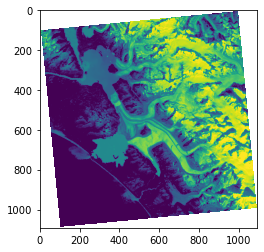

In [74]:
rio.plot.show(basemap)

Plot with matplot (uses good colormap)

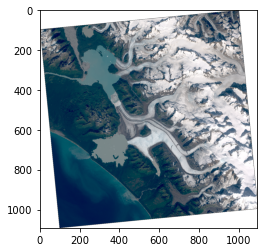

In [75]:
plt.imshow(mpimg.imread(basemap_fn))

# Import ArcticDEM
Jun was right--Polar Geospatial Center's website is down. Luckily I already have downloaded the DEM of interest. If you wanted to get it yourself when the PGC website was running, you'd go to http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v3.0/2m/42_06/42_06_2_2_2m_v3.0.tar.gz and then extract the DEM from that archive. 

I've saved it (for now) at crossovers/contributors/loso/ArcticDEM

### Find and open dem as a dataset object using rasterio

Rasterio documentation: https://rasterio.readthedocs.io/en/stable/

There are three versions of the DEM available. Native version is 2 m and untiled: 42_06_2_2_2m_v3.0_reg_dem.tif
I resampled with gdalwarp to 10m and 100m resolution to make it easier to work with and visualize. Filenames of those differ only by changing "2m" to "10m" or "100m" respectively

In [76]:
path_to_ArcticDEM_folder = '/srv/shared/data-crossovers/ArcticDEM/42_06_2_2_10m_v3.0_reg_dem_32607.tif'
ArcticDEM_src = rio.open(path_to_ArcticDEM_folder)

### Verify CRS, profile, and pixel dimensions (it is square). Also generate extent.

In [77]:
print(ArcticDEM_src.profile)
print(ArcticDEM_src.crs)
ArcticDEM_extent = rio.plot.plotting_extent(ArcticDEM_src)
print(ArcticDEM_extent)
print(ArcticDEM_src.height)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 5461, 'height': 5461, 'count': 1, 'crs': CRS.from_epsg(32607), 'transform': Affine(9.578773446933079, 0.0, 650017.1713167848,
       0.0, -9.578773446933079, 6579617.665651759), 'tiled': False, 'interleave': 'band'}
EPSG:32607
(650017.1713167848, 702326.8531104864, 6527307.983858057, 6579617.665651759)
5461


### Reproject extent into lat/Long

In [104]:
from pyproj import Proj, transform

inProj = Proj('EPSG:32607')
outProj = Proj('EPSG:4326')
x = ArcticDEM_extent[0:2]
y = ArcticDEM_extent[2:4]
ArcticDEM_extent_latlong = transform(inProj,outProj,x,y)
print(ArcticDEM_extent_latlong)

((58.85936873949439, 59.306828871347534), (-138.3990209216774, -137.44559547328527))


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  import sys


### Create NumPY array

In [85]:
print(ArcticDEM_extent)

(650017.1713167848, 702326.8531104864, 6527307.983858057, 6579617.665651759)


In [78]:
arcticdem = ArcticDEM_src.read(1, masked=True)

### Simple plot

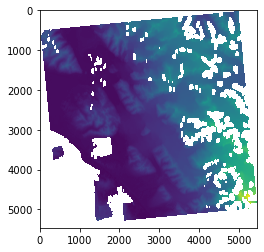

In [79]:
rio.plot.show(arcticdem)

## Generate shaded relief map
* Many ways to do this, but we'll just use the `gdaldem` command line utility for simplicity

In [ ]:
hs_fn = os.path.splitext(srtm_fn)[0]+'_hs.tif'
if not os.path.exists(hs_fn):
    !gdaldem hillshade $srtm_fn $hs_fn

In [ ]:
srtm_hs_src = rio.open(hs_fn)
hs = srtm_hs_src.read(1, masked=True)

## Plot color shaded relief map

In [ ]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(srtm_hs_src))
ax.imshow(srtm, extent=srtm_extent, alpha=0.5);

### Reproject GLAS points to match raster

In [51]:
import gdal, osr 
import numpy as np

def raster2array(geotif_file):

    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==metadata['noDataValue']]=np.nan
        array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [52]:
def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2

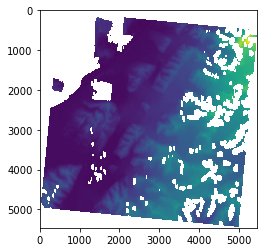

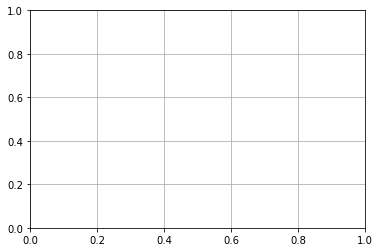

In [80]:
# Use raster2array to convert \Geotif to array & plot
arcticdem_array, arcticdem_md = raster2array(path_to_ArcticDEM_folder)
#plot_band_array(arcticdem_array,arcticdem_md['extent'],'ArcticDEM','Elevation, m',colormap='gist_earth')
rio.plot.show(arcticdem_array)
ax = plt.gca(); plt.grid('on')

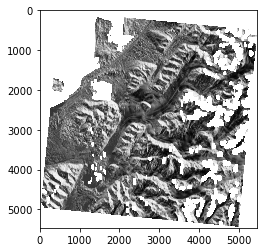

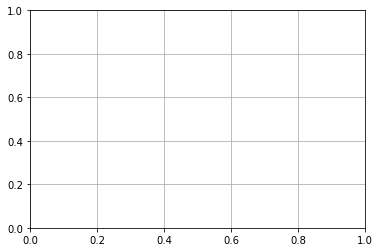

In [82]:
# Use hillshade function on a DTM Geotiff
arcticdem_hs = hillshade(arcticdem_array,225,45)
rio.plot.show(arcticdem_hs,cmap='Greys')
#plot_band_array(teak_hillshade_array,teak_dtm_md['extent'],'TEAK Hillshade, Aspect=225°', 'Hillshade',colormap='Greys',alpha=0.8)
ax = plt.gca(); plt.grid('on') 

In [ ]:
fig = plt.figure(frameon=False)
im1 = plt.imshow(teak_dtm_array,cmap='terrain_r',extent=teak_dtm_md['extent']); 
cbar = plt.colorbar(); cbar.set_label('Elevation, m',rotation=270,labelpad=20)
im2 = plt.imshow(teak_hillshade_array,cmap='Greys',alpha=0.8,extent=teak_dtm_md['extent']); 
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.grid('on'); # plt.colorbar(); 
plt.title('TEAK Hillshade + DTM')